In [1]:
# импортируем библиотеки
import numpy as np
from scipy import linalg

Входные данные

In [11]:
var("x,y,z,gamma")
epsilon0=1
epsilon1=1.1
mu=1
Lx=1
Ly=2
# Интеграл по сечению волновода
def integral_on_S(u):
    return integral(integral(u,(x,0,Lx)),(y,0,Ly))
# Интеграл по вставке
def integral_on_S1(u):
    return integral(integral(u,(x,0,Lx)),(y,0,Ly/2))
# Рассматриваемые числовые значения gamma
list_gamma_values = list(np.arange(0,5,0.25))
# Число базисных функций Дирихле/Неймана
MD=6/2
ND=6/2
MN=6/2
NN=6/2
# Число ядер процессора, используемых при вычислениях
ncores=4

In [12]:
# Списки индексов собственных функций сечения
dirichlet_index=[[n,m] for n in range(1,MD+1) for m in range(1,ND+1)]
neumann_index=[[n,m] for n in range(MN) for m in range(NN) if n+m>0]
M1=len(dirichlet_index)
M2=len(neumann_index)
dn_index = neumann_index + dirichlet_index

def alpha(n,m):
    return sqrt(pi^2*n^2/Lx^2+pi^2*m^2/Ly^2)
def beta(n,m):
    return sqrt(pi^2*n^2/Lx^2+pi^2*m^2/Ly^2)

q = (1/epsilon1 - 1/epsilon0)/mu

# подсчет первого выражения на странице 22
def d11(n1,m1,n2,m2,f11,ff11):
    '''
    f11 - вызов функции, которая считает двойной интеграл
    ff11- аналогичо
    '''
    return q * (gamma^2/alpha(n1,m1)/alpha(n2,m2)*ff11+ alpha(n1,m1)*alpha(n2,m2)*f11)

# подсчет второго выражения на странице 22
def d12(n1,m1,n2,m2,f12):
    return q * (gamma*sqrt(beta(n2,m2)^2+gamma^2)/alpha(n1,m1)/beta(n2,m2)*f12)

# подсчет третьего выражения на странице 22
def d22(n1,m1,n2,m2,f22):
    return q * (sqrt(beta(n1,m1)^2+gamma^2)*sqrt(beta(n2,m2)^2+gamma^2)/beta(n1,m1)/beta(n2,m2)*f22)

# функции для подсчета значений f_nm на странице 23
var("n1,m1,n2,m2")

def g11(phi1,phi2):
    return integral_on_S1(phi1*phi2)

def g22(psi1,psi2):
    return integral_on_S1(diff(psi1,x)*diff(psi2,x)+diff(psi1,y)*diff(psi2,y))

def g12(phi1,psi2):
    # почему здесь минус? Это подсчет интеграла во втором выражении d'_n,m на странице 22? -- Потому что это определитель
    return integral_on_S1(diff(psi2,x)*diff(phi1,y)-diff(psi2,y)*diff(phi1,x))

# Базисные функции и интегралы от них как символьные выражение от n1,m1,n2,m2
norm=sqrt(Lx/2*Ly/2)
phi1=sin(pi*n1*x/Lx)*sin(pi*m1*y/Ly)/norm
phi2=sin(pi*n2*x/Lx)*sin(pi*m2*y/Ly)/norm
phi2n=sin(pi*n1*x/Lx)*sin(pi*m2*y/Ly)/norm
phi2m=sin(pi*n2*x/Lx)*sin(pi*m1*y/Ly)/norm


# Отдельно рассматриваем случаи n1!=n2 и n1==n2, m1!=m2 и m1==m2, 
# поскольку общая формула не работает в особых случаях.
f11=g11(phi1,phi2)
f11n=g11(phi1,phi2n)
f11m=g11(phi1,phi2m)
f11nm=g11(phi1,phi1)

ff11=g22(phi1,phi2)
ff11n=g22(phi1,phi2n)
ff11m=g22(phi1,phi2m)
ff11nm=g22(phi1,phi1)
    
psi1=cos(pi*n1*x/Lx)*cos(pi*m1*y/Ly)/norm
psi2=cos(pi*n2*x/Lx)*cos(pi*m2*y/Ly)/norm
psi2n=cos(pi*n1*x/Lx)*cos(pi*m2*y/Ly)/norm
psi2m=cos(pi*n2*x/Lx)*cos(pi*m1*y/Ly)/norm

f22=g22(psi1,psi2)
f22n=g22(psi1,psi2n)
f22m=g22(psi1,psi2m)
f22nm=g22(psi1,psi1)

f12=g12(phi1,psi2)
f12n=g12(phi1,psi2n)
f12m=g12(phi1,psi2m)
f12nm=g12(phi1,psi1)
    
norm0=sqrt(Lx*Ly/2)
psi1n0=cos(pi*m1*y/Ly)/norm0
psi2n0=cos(pi*m2*y/Ly)/norm0
f22n0=g22(psi1n0,psi2n0)
f22n0m=g22(psi1n0,psi1n0)

psi1m0=cos(pi*n1*x/Lx)/norm0
psi2m0=cos(pi*n2*x/Lx)/norm0
f22m0=g22(psi1m0,psi2m0)
f22m0n=g22(psi1m0,psi1m0)

# Правила заполнения D0 и D1
def foo(i,j, gamma):
    if i<M1 and j<M1:
        [vn1,vm1] =dirichlet_index[i]
        [vn2,vm2] =dirichlet_index[j]
        S=[n1==vn1, m1==vm1, n2==vn2, m2==vm2]
        if i==j:
            ans = d11(n1,m1,n2,m2,f11nm,ff11nm).subs(S)
        elif vn1==vn2 and vm1!=vm2:
            ans = d11(n1,m1,n2,m2,f11n,ff11n).subs(S)
        elif vn1!=vn2 and vm1==vm2:
            ans = d11(n1,m1,n2,m2,f11m,ff11m).subs(S)
        else:
            ans = d11(n1,m1,n2,m2,f11,ff11).subs(S)
    elif i<M1 and j>=M1:
        [vn1,vm1] =dirichlet_index[i]
        [vn2,vm2] =neumann_index[j-M1]
        S=[n1==vn1, m1==vm1, n2==vn2, m2==vm2]
        if vn1==vn2 and vm1==vm2:
            ans = d12(n1,m1,n2,m2,f12nm).subs(S)
        elif vn1==vn2 and vm1!=vm2:
            ans = d12(n1,m1,n2,m2,f12n).subs(S)
        elif vn1!=vn2 and vm1==vm2:
            ans = d12(n1,m1,n2,m2,f12m).subs(S)
        else:
            ans = d12(n1,m1,n2,m2,f12).subs(S)
    elif i>=M1 and j<M1:
        [vn1,vm1] =dirichlet_index[j]
        [vn2,vm2] =neumann_index[i-M1]
        S=[n1==vn1, m1==vm1, n2==vn2, m2==vm2]
        if vn1==vn2 and vm1==vm2:
            ans = d12(n1,m1,n2,m2,f12nm).subs(S)
        elif vn1==vn2 and vm1!=vm2:
            ans = d12(n1,m1,n2,m2,f12n).subs(S)
        elif vn1!=vn2 and vm1==vm2:
            ans = d12(n1,m1,n2,m2,f12m).subs(S)
        else:
            ans = d12(n1,m1,n2,m2,f12).subs(S)
    else:
        [vn1,vm1] =neumann_index[i-M1]
        [vn2,vm2] =neumann_index[j-M1]
        S=[n1==vn1, m1==vm1, n2==vn2, m2==vm2]
        if vn1==0 and vn2==0:
            if vm1==vm2:
                ans=d22(n1,m1,n2,m2,f22n0m).subs(S)
            else:
                ans=d22(n1,m1,n2,m2,f22n0).subs(S)
        elif vm1==0 and vm2==0:
            if vn1==vn2:
                ans=d22(n1,m1,n2,m2,f22m0n).subs(S)
            else:
                ans=d22(n1,m1,n2,m2,f22m0).subs(S)
        else:
            if i==j:
                ans = d22(n1,m1,n2,m2,f22nm).subs(S)
            elif vn1==vn2 and vm1!=vm2:
                ans = d22(n1,m1,n2,m2,f22n).subs(S)
            elif vn1!=vn2 and vm1==vm2:
                ans = d22(n1,m1,n2,m2,f22m).subs(S)
            else:
                ans = d22(n1,m1,n2,m2,f22).subs(S)
    return ans

def foo2(i,j, gamma):
    if i!=j:
        ans=0
    elif i<M1:
        [vn,vm]=dirichlet_index[i]
        # формула со сраницы 22 для подсчета элементов диагональной матрицы
        ans=(gamma^2+alpha(vn,vm)^2)/mu/epsilon0
    else:
        [vn,vm]=neumann_index[i-M1]
        ans=(gamma^2+beta(vn,vm)^2)/mu/epsilon0
    return ans

# Матрица D при gamma, равном численному значению ngamma.

def D(ngamma):
    D1 = matrix(RR,M1+M2, M1+M2, lambda i,j: foo(i,j, gamma).subs(gamma=ngamma))
    D0 = matrix(RR,M1+M2, M1+M2, lambda i,j: foo2(i,j, gamma).subs(gamma=ngamma))
    return D0 + D1

# С.з. матрицы D при gamma, равном численному значению ngamma. 
@parallel(ncores)
def k_square(ngamma):
    a = np.array(list(D(ngamma)))
    return [ngamma, linalg.eigvals(a)]

In [13]:
# Проверка нормировки в L2
# integral_on_S(psi1m0^2).subs([m1==5, n1==2])

In [14]:
L=list(k_square(list_gamma_values))

In [15]:
#L[*][1][0 -- значение gamma, 1 -- список с.з.]
L[1][1][1]

array([ 30.88644922+0.j,  19.10753963+0.j,  19.09794351+0.j,
        11.96211882+0.j,  12.13218606+0.j,   9.52118064+0.j,
        59.26018487+0.j,  36.49364487+0.j,  39.85689454+0.j,
        41.56901242+0.j,  47.62524667+0.j,  47.48018286+0.j,
       106.73406208+0.j,  95.5469668 +0.j,  85.77495379+0.j,
         2.58809396+0.j,   9.66541129+0.j])

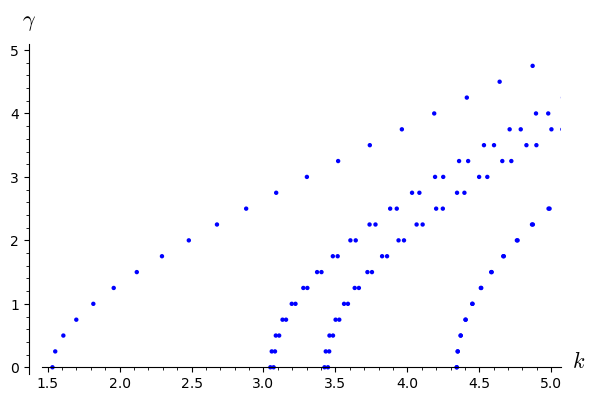

In [16]:
var("k")
LL=[[[sqrt(RR(i)), L[j][1][0]] for i in L[j][1][1]] for j in range(len(list_gamma_values))]
plot1=sum(points(LL[j], axes_labels=["$k$", '$\\gamma$'], xmax=5, ymax=5) for j in range(len(list_gamma_values)))
plot1

In [17]:
n=1
kz=gamma
kx=pi*n/Lx
a11=sin(sqrt(epsilon1*mu*k^2 - kx^2 - kz^2)*Ly/2)
a12=sinh(sqrt(kx^2 + kz^2 -epsilon0*mu*k^2)*Ly/2)
a21=-sqrt(epsilon1*mu*k^2 - kx^2 - kz^2)*cos(sqrt(epsilon1*mu*k^2 - kx^2 - kz^2)*Ly/2)
a22=sqrt(kx^2 + kz^2 -epsilon0*mu*k^2)*cosh(sqrt(kx^2 + kz^2 -epsilon0*mu*k^2)*Ly/2)
A=matrix([[a11,a12],[a21,a22]])
a11=sin(sqrt(epsilon1*mu*k^2 - kx^2 - kz^2)*Ly/2)
a12=sin(sqrt(epsilon0*mu*k^2 - kx^2 - kz^2)*Ly/2)
a21=sqrt(epsilon1*mu*k^2 - kx^2 - kz^2)*cos(sqrt(epsilon1*mu*k^2 - kx^2 - kz^2)*Ly/2)
a22=-sqrt(epsilon0*mu*k^2 - kx^2 - kz^2)*cos(sqrt(epsilon0*mu*k^2 - kx^2 - kz^2)*Ly/2)
B=matrix([[a11,a12],[a21,a22]])

/usr/lib64/python3.9/site-packages/sage/plot/contour_plot.py:206: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


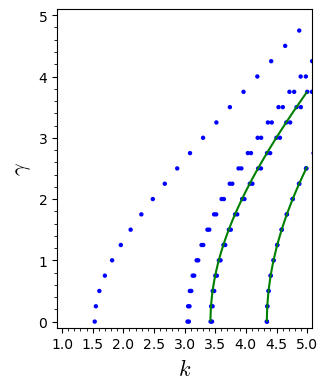

In [18]:
plot2=implicit_plot(A.det()==0, (k,1,5),(kz,0,5), color="red")+implicit_plot(B.det()==0, (k,1,5),(kz,0,5), color="green")+plot1
plot2

In [19]:
plot2.save(f'new e1={epsilon1}, MD={MD}, MN={MN}, ND={ND}, NN={NN}.pdf')